# <center>Домашняя работа по лекции 16
# <center>Reinforcement learning - обучение с подкреплением
# <center>на примеры игы в крестики-нолики
### Задание:
Опираясь на табличное обучение с подкреплением реализовать и обучить нейронную Q-функцию.

#### Решение здесь - через **V**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

In [2]:
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
# Copied from https://github.com/neilslater/game_playing_scripts

'''
   Copyright 2017 Neil Slater

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
'''

import numpy as np
import random

class TicTacToeGame():
    def __init__(self):
        self.state = '         '
        self.player = 'X'
        self.winner = None

    def allowed_moves(self):
        states = []
        for i in range(len(self.state)):
            if self.state[i] == ' ':
                states.append(self.state[:i] + self.player + self.state[i+1:])
        return states

    def make_move(self, next_state):  # или ход привел к чьей-то победе, или переход хода
        if self.winner:
            raise(Exception("Game already completed, cannot make another move!"))
        if not self.__valid_move(next_state):
            raise(Exception("Cannot make move {} to {} for player {}".format(
                    self.state, next_state, self.player)))

        self.state = next_state
        self.winner = self.predict_winner(self.state)
        if self.winner:
            self.player = None
        elif self.player == 'X':
            self.player = 'O'
        else:
            self.player = 'X'

    def playable(self):
        return ( (not self.winner) and any(self.allowed_moves()) )  # победителя еще нет и есть доступные ходы

    def predict_winner(self, state):
        lines = [(0,1,2), (3,4,5), (6,7,8), (0,3,6), (1,4,7), (2,5,8), (0,4,8), (2,4,6)]
        winner = None
        for line in lines:
            line_state = state[line[0]] + state[line[1]] + state[line[2]]
            if line_state == 'XXX':
                winner = 'X'
            elif line_state == 'OOO':
                winner = 'O'
        return winner

    def __valid_move(self, next_state):
        allowed_moves = self.allowed_moves()
        if any(state == next_state for state in allowed_moves):
            return True
        return False

    def print_board(self):
        s = self.state
        print('     {} | {} | {} '.format(s[0],s[1],s[2]))
        print('    -----------')
        print('     {} | {} | {} '.format(s[3],s[4],s[5]))
        print('    -----------')
        print('     {} | {} | {} '.format(s[6],s[7],s[8]))


In [5]:
class Agent():
    def __init__(self, game_class, model, criterion, epsilon=0.1, vdelta=0.01, 
                 lr=0.001, gamma=1.0, player_mark='X', epoch_size=1000, batch_size=100):
        self.V = model.to(device)
        self.NewGame = game_class
        self.epsilon = epsilon
        self.vdelta = vdelta
        self.criterion = criterion
        self.optimizer = torch.optim.Adadelta(self.V.parameters())
        self.player_mark = player_mark
        self.gamma = gamma
        self.alpha = 0.9
        self.losses = []
        self.total_episode = 0
        self.history = {'positions': [], 'moves': [], 'rewards': []}
        self.batches = None
        self.epoch_size = epoch_size
        self.batch_size = batch_size

    def history_reset(self):
        self.history = {'positions': [], 'moves': [], 'rewards': []}
    
    @staticmethod
    def statetotensor(state):
        sign_to_value = {"X": 1.0, "O": -1.0, " ": 0.0}
        tensor = torch.FloatTensor([sign_to_value[item] for item in state]).requires_grad_(True).view(1, len(state)).to(device)
        return tensor

    def state_value(self, game_state, V_freezed=None):
        V = V_freezed or self.V
        if game_state:
            value = V(self.statetotensor(game_state))
        else:
            value = torch.FloatTensor([0.]).requires_grad_(True).view(1, 1).to(device)
        return value

    def learn_game(self, num_episodes=1000, reset=False):
        if reset:
            self.total_episode = 0
            self.history_reset()
        for episode in range(num_episodes):
            self.learn_from_episode()
            self.total_episode += 1
    
    def learn_from_episode(self): 
        game = self.NewGame()
        _, move = self.learn_select_move(game)  # выбираем начальный ход (учитываем заданное правило)
        while move:
            move = self.learn_from_move(game, move)
        if self.total_episode % self.epoch_size == 0 and self.total_episode > 0:
            self.process_learning()
            self.history_reset()

    def _batching(self):
        self.batches = []
        batch = []
        for i in range(len(self.history['moves'])):
            state = self.history['positions'][i]
            best_next_move = self.history['moves'][i]
            r = self.history['rewards'][i]
            batch.append([state, best_next_move, r])
            if (i + 1) % self.batch_size == 0:
                self.batches.append(batch)
                batch = []
        return self.batches

    def process_learning(self):
        """update policy table based on latest game"""
        self._batching()
        # raise(ValueError)

        V_freezed = copy.deepcopy(self.V).requires_grad_(False)
        for batch in self.batches:
            loss = 0
            for state, best_next_move, r in batch:
                current_state_value = self.state_value(state)
                next_state_value = self.state_value(best_next_move, V_freezed)

                td_target = r + self.gamma * next_state_value
                loss += self.criterion(current_state_value, td_target)

            loss /= len(batch)
            # обучаем сеть
            self.V.zero_grad()
            self.losses.append(loss.data.item())
            loss.backward()
            # делаем шаг в сторону улучшения модели
            self.optimizer.step()
                                        
    @staticmethod
    def digit_to_target(digit):
        return torch.FloatTensor([digit]).view(1, 1).requires_grad_(True).to(device)
    
    def learn_from_move(self, game, move):
        """
        make move and collect learning from it
        """
        game.make_move(move)  # проверяет, есть ли победитель в game.winner, и если нет - переход хода
        r = self.__reward(game)  # вычисляем вознаграждение за ход move
        next_state_value = 0.0
        selected_next_move = None
        if game.playable():  # победителя еще нет и есть доступные ходы
            with torch.no_grad():
                best_next_move, selected_next_move = self.learn_select_move(game)
        
        
        self.history['positions'].append(move)
        self.history['rewards'].append(r)
        self.history['moves'].append(selected_next_move) 

        return selected_next_move

    def learn_select_move(self, game):
        allowed_state_values = self.__state_values(game.allowed_moves())  # словарь состояние-значение
        if game.player == self.player_mark:
            best_move = self.__argmax_V(allowed_state_values)
        else:
            best_move = self.__argmin_V(allowed_state_values)

        selected_move = best_move
        if random.random() < self.epsilon:   # добавляем случайный ход (pздесь - в 10%, согласно epsilon)
            selected_move = self.__random_V(allowed_state_values)

        return (best_move, selected_move)

    def play_select_move(self, game):
        allowed_state_values = self.__state_values(game.allowed_moves())  # словарь с доступными ходами и их values
        if game.player == self.player_mark:
            return self.__argmax_V(allowed_state_values)  # выбираем наулучших ход для player_mark
        else:
            # ходит "не player_mark": выбираем наулучших ход для "не player_mark" (== наихудший для player_mark)
            return self.__argmin_V(allowed_state_values)  
    
    def demo_game(self, verbose=False):
        game = self.NewGame()
        t = 0
        while game.playable():  # пока нет победителя и есть доступные ходы
            if verbose:
                print(" \nTurn {}\n".format(t))
                game.print_board()
            move = self.play_select_move(game)
            game.make_move(move)  # или ход привел к чьей-то победе, или переход хода
            t += 1
        if verbose:
            print(" \nTurn {}\n".format(t))
            game.print_board()
        if game.winner:
            if verbose:
                print("\n{} is the winner!".format(game.winner))
            return game.winner
        else:
            if verbose:
                print("\nIt's a draw!")
            return '-'

    def interactive_game(self, agent_player='X'):
        game = self.NewGame()
        t = 0
        while game.playable():
            print(" \nTurn {}\n".format(t))
            game.print_board()
            if game.player == agent_player:
                move = self.play_select_move(game)  # делаем ход (выбранное новое состояние)
                game.make_move(move)
            else:
                move = self.__request_human_move(game)
                game.make_move(move)
            t += 1

        print(" \nTurn {}\n".format(t))
        game.print_board()

        if game.winner:
            print("\n{} is the winner!".format(game.winner))
            return game.winner
        print("\nIt's a draw!")
        return '-'

    def __state_values(self, game_states):
        return dict((state, self.state_value(state)) for state in game_states)

    def __argmax_V(self, state_values):
        max_V = max(state_values.values())
        chosen_state = random.choice([state for state, v in state_values.items() if v >= max_V - self.vdelta])
        return chosen_state

    def __argmin_V(self, state_values):
        min_V = min(state_values.values())
        chosen_state = random.choice([state for state, v in state_values.items() if v <= min_V + self.vdelta])
        return chosen_state

    def __random_V(self, state_values):
        return random.choice(list(state_values.keys()))

    def __reward(self, game):
        if game.winner == self.player_mark:
            return 1.0
        elif game.winner:
            return -1.0
        else:
            return 0.0

    def __request_human_move(self, game):
        allowed_moves = [i+1 for i in range(9) if game.state[i] == ' ']
        human_move = None
        while not human_move:
            idx = int(input('Choose move for {}, from {} : '.format(game.player, allowed_moves)))
            if any([i==idx for i in allowed_moves]):
                human_move = game.state[:idx-1] + game.player + game.state[idx:]
        return human_move

In [6]:
class VModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(9, 50) 
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, 50)
        self.fc5 = nn.Linear(50, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [7]:
def demo_game_stats(agent, games_num=1000):
    results = [agent.demo_game() for i in range(games_num)]
    game_stats = {k: round(results.count(k) / games_num * 100, 1) for k in ['X', 'O', '-']}
    print("    percentage results: {}".format(game_stats))

In [8]:
%%time

agent = Agent(TicTacToeGame, model=VModel(), criterion=nn.MSELoss(), epsilon=0.3, vdelta=0.02, lr=0.1, gamma=1.0)
total_episodes = 0
print("Before learning:")
demo_game_stats(agent)

num_episodes = 5_000
total_episodes += num_episodes
agent.learn_game(num_episodes)
print(f"After {total_episodes} learning games:")
demo_game_stats(agent)

Before learning:
    percentage results: {'X': 59.2, 'O': 28.5, '-': 12.3}
After 5000 learning games:
    percentage results: {'X': 73.8, 'O': 12.4, '-': 13.8}
Wall time: 1min 38s


In [9]:
%%time

num_episodes = 5_000
total_episodes += num_episodes
agent.learn_game(num_episodes)
print(f"After {total_episodes} learning games:")
demo_game_stats(agent)

After 10000 learning games:
    percentage results: {'X': 24.6, 'O': 49.9, '-': 25.5}
Wall time: 1min 32s


In [10]:
%%time

num_episodes = 10_000
total_episodes += num_episodes
agent.learn_game(num_episodes)
print(f"After {total_episodes} learning games:")
demo_game_stats(agent)

After 20000 learning games:
    percentage results: {'X': 0.0, 'O': 0.0, '-': 100.0}
Wall time: 2min 47s


In [21]:
%%time

num_episodes = 10_000
total_episodes += num_episodes
agent.learn_game(num_episodes)
print(f"After {total_episodes} learning games:")
demo_game_stats(agent)

After 30000 learning games:
    percentage results: {'X': 0.0, 'O': 0.0, '-': 100.0}
Wall time: 2min 26s


#### Посмотрим сэмплы в одном из батчей, чтобы посчитать Value для состояний с известными Value

In [22]:
agent.batches[2]

[['    X    ', '    X   O', 0.0],
 ['    X   O', '    X  XO', 0.0],
 ['    X  XO', ' O  X  XO', 0.0],
 [' O  X  XO', ' OX X  XO', 0.0],
 [' OX X  XO', ' OX X OXO', 0.0],
 [' OX X OXO', ' OXXX OXO', 0.0],
 [' OXXX OXO', ' OXXXOOXO', 0.0],
 [' OXXXOOXO', 'XOXXXOOXO', 0.0],
 ['XOXXXOOXO', None, 0.0],
 ['    X    ', 'O   X    ', 0.0],
 ['O   X    ', 'OX  X    ', 0.0],
 ['OX  X    ', 'OXO X    ', 0.0],
 ['OXO X    ', 'OXO X  X ', 0.0],
 ['OXO X  X ', None, 1.0],
 ['    X    ', 'O   X    ', 0.0],
 ['O   X    ', 'OX  X    ', 0.0],
 ['OX  X    ', 'OX  X  O ', 0.0],
 ['OX  X  O ', 'OX  X XO ', 0.0],
 ['OX  X XO ', 'OXO X XO ', 0.0],
 ['OXO X XO ', 'OXO XXXO ', 0.0],
 ['OXO XXXO ', 'OXOOXXXO ', 0.0],
 ['OXOOXXXO ', 'OXOOXXXOX', 0.0],
 ['OXOOXXXOX', None, 0.0],
 ['    X    ', 'O   X    ', 0.0],
 ['O   X    ', 'OX  X    ', 0.0],
 ['OX  X    ', 'OX  X  O ', 0.0],
 ['OX  X  O ', 'OX  X  OX', 0.0],
 ['OX  X  OX', 'OX OX  OX', 0.0],
 ['OX OX  OX', 'OX OX XOX', 0.0],
 ['OX OX XOX', 'OXOOX XOX', 0.0],
 

#### Посмотрим Value для некторых комбинаций и сравним с тем, что должно быть

In [23]:
round(agent.state_value('XOOOXXXXO').item(), 4)  # = 0

-0.0428

In [24]:
round(agent.state_value('O  OXXOX ').item(), 4)  # = -1

-0.861

In [25]:
round(agent.state_value('O  XXXO  ').item(), 4)  # = 1

0.8076

In [26]:
round(agent.state_value('X X XOXOO').item(), 4)  # = 1

1.1971

In [27]:
round(agent.state_value(' X  X OXO').item(), 4)  # = 1

1.0191

In [28]:
round(agent.state_value(' OXOX X  ').item(), 4)  # = 1

1.026

In [33]:
round(agent.state_value('OXOOXXXOX').item(), 4)  # = 0

-0.031

In [30]:
round(agent.state_value('OXOXXOXOX').item(), 4)  # = 0

-0.0349

**Резюме:** **все** выигрыши, проигрыши и ничьи определены **верно** 

#### Посмотрим, как обучился первый ход X

In [31]:
for i in range(9):
    state = [' '] * 9
    state[i] = 'X'
    state = ''.join(state)
    print(i + 1, state, round(agent.state_value(state).item(), 4))

1 X         0.0605
2  X        -0.0072
3   X       -0.005
4    X      -0.0248
5     X     0.2087
6      X    -0.0346
7       X   0.0135
8        X  -0.0386
9         X 0.0465


**Резюме:** первый ход обучился правильно (по центру, см. 5 строку)

#### Первый ход для **О**

In [32]:
state = [' '] * 9
state[4] = 'X'
for i in range(9):
    state_ = state.copy()
    if i + 1 != 5:
        state_[i] = 'O'
        state_ = ''.join(state_)
        print(i + 1, state_, round(agent.state_value(state_).item(), 4))

1 O   X     0.1761
2  O  X     0.463
3   O X     0.2528
4    OX     0.334
6     XO    0.4002
7     X O   0.2161
8     X  O  0.4775
9     X   O 0.2109


**Резюме:** первый ход для **О** обучился правильно (в угол, см. 1 строку). кроме того, все угловые ходы имеют более высокий приоритет (с учетом того, что для **О** мы вибираем по минимуму), что как раз оптимальнее.

In [49]:
# len(agent.history['moves'])

In [50]:
# agent.history['rewards']

In [51]:
# agent.history['positions']

In [52]:
# agent.history['rewards']

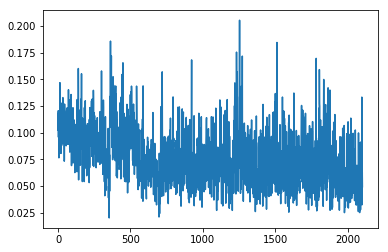

In [34]:
plt.plot(agent.losses);

In [35]:
agent.demo_game(True)

 
Turn 0

       |   |   
    -----------
       |   |   
    -----------
       |   |   
 
Turn 1

       |   |   
    -----------
       | X |   
    -----------
       |   |   
 
Turn 2

     O |   |   
    -----------
       | X |   
    -----------
       |   |   
 
Turn 3

     O |   |   
    -----------
       | X |   
    -----------
     X |   |   
 
Turn 4

     O |   | O 
    -----------
       | X |   
    -----------
     X |   |   
 
Turn 5

     O | X | O 
    -----------
       | X |   
    -----------
     X |   |   
 
Turn 6

     O | X | O 
    -----------
       | X |   
    -----------
     X | O |   
 
Turn 7

     O | X | O 
    -----------
       | X | X 
    -----------
     X | O |   
 
Turn 8

     O | X | O 
    -----------
     O | X | X 
    -----------
     X | O |   
 
Turn 9

     O | X | O 
    -----------
     O | X | X 
    -----------
     X | O | X 

It's a draw!


'-'

In [36]:
agent.interactive_game()

 
Turn 0

       |   |   
    -----------
       |   |   
    -----------
       |   |   
 
Turn 1

       |   |   
    -----------
       | X |   
    -----------
       |   |   


Choose move for O, from [1, 2, 3, 4, 6, 7, 8, 9] :  1


 
Turn 2

     O |   |   
    -----------
       | X |   
    -----------
       |   |   
 
Turn 3

     O |   |   
    -----------
       | X |   
    -----------
     X |   |   


Choose move for O, from [2, 3, 4, 6, 8, 9] :  3


 
Turn 4

     O |   | O 
    -----------
       | X |   
    -----------
     X |   |   
 
Turn 5

     O | X | O 
    -----------
       | X |   
    -----------
     X |   |   


Choose move for O, from [4, 6, 8, 9] :  8


 
Turn 6

     O | X | O 
    -----------
       | X |   
    -----------
     X | O |   
 
Turn 7

     O | X | O 
    -----------
       | X | X 
    -----------
     X | O |   


Choose move for O, from [4, 9] :  4


 
Turn 8

     O | X | O 
    -----------
     O | X | X 
    -----------
     X | O |   
 
Turn 9

     O | X | O 
    -----------
     O | X | X 
    -----------
     X | O | X 

It's a draw!


'-'

In [37]:
agent.interactive_game()

 
Turn 0

       |   |   
    -----------
       |   |   
    -----------
       |   |   
 
Turn 1

       |   |   
    -----------
       | X |   
    -----------
       |   |   


Choose move for O, from [1, 2, 3, 4, 6, 7, 8, 9] :  2


 
Turn 2

       | O |   
    -----------
       | X |   
    -----------
       |   |   
 
Turn 3

       | O | X 
    -----------
       | X |   
    -----------
       |   |   


Choose move for O, from [1, 4, 6, 7, 8, 9] :  7


 
Turn 4

       | O | X 
    -----------
       | X |   
    -----------
     O |   |   
 
Turn 5

       | O | X 
    -----------
       | X |   
    -----------
     O |   | X 


Choose move for O, from [1, 4, 6, 8] :  6


 
Turn 6

       | O | X 
    -----------
       | X | O 
    -----------
     O |   | X 
 
Turn 7

     X | O | X 
    -----------
       | X | O 
    -----------
     O |   | X 

X is the winner!


'X'

In [38]:
agent.interactive_game()

 
Turn 0

       |   |   
    -----------
       |   |   
    -----------
       |   |   
 
Turn 1

       |   |   
    -----------
       | X |   
    -----------
       |   |   


Choose move for O, from [1, 2, 3, 4, 6, 7, 8, 9] :  8


 
Turn 2

       |   |   
    -----------
       | X |   
    -----------
       | O |   
 
Turn 3

       |   |   
    -----------
       | X |   
    -----------
     X | O |   


Choose move for O, from [1, 2, 3, 4, 6, 9] :  3


 
Turn 4

       |   | O 
    -----------
       | X |   
    -----------
     X | O |   
 
Turn 5

     X |   | O 
    -----------
       | X |   
    -----------
     X | O |   


Choose move for O, from [2, 4, 6, 9] :  4


 
Turn 6

     X |   | O 
    -----------
     O | X |   
    -----------
     X | O |   
 
Turn 7

     X |   | O 
    -----------
     O | X |   
    -----------
     X | O | X 

X is the winner!


'X'

In [39]:
agent.interactive_game()

 
Turn 0

       |   |   
    -----------
       |   |   
    -----------
       |   |   
 
Turn 1

       |   |   
    -----------
       | X |   
    -----------
       |   |   


Choose move for O, from [1, 2, 3, 4, 6, 7, 8, 9] :  7


 
Turn 2

       |   |   
    -----------
       | X |   
    -----------
     O |   |   
 
Turn 3

       |   |   
    -----------
       | X |   
    -----------
     O | X |   


Choose move for O, from [1, 2, 3, 4, 6, 9] :  2


 
Turn 4

       | O |   
    -----------
       | X |   
    -----------
     O | X |   
 
Turn 5

     X | O |   
    -----------
       | X |   
    -----------
     O | X |   


Choose move for O, from [3, 4, 6, 9] :  9


 
Turn 6

     X | O |   
    -----------
       | X |   
    -----------
     O | X | O 
 
Turn 7

     X | O |   
    -----------
       | X | X 
    -----------
     O | X | O 


Choose move for O, from [3, 4] :  4


 
Turn 8

     X | O |   
    -----------
     O | X | X 
    -----------
     O | X | O 
 
Turn 9

     X | O | X 
    -----------
     O | X | X 
    -----------
     O | X | O 

It's a draw!


'-'

In [61]:
agent.interactive_game()

 
Turn 0

       |   |   
    -----------
       |   |   
    -----------
       |   |   
 
Turn 1

       |   |   
    -----------
       | X |   
    -----------
       |   |   


Choose move for O, from [1, 2, 3, 4, 6, 7, 8, 9] :  6


 
Turn 2

       |   |   
    -----------
       | X | O 
    -----------
       |   |   
 
Turn 3

       |   |   
    -----------
       | X | O 
    -----------
       |   | X 


Choose move for O, from [1, 2, 3, 4, 7, 8] :  1


 
Turn 4

     O |   |   
    -----------
       | X | O 
    -----------
       |   | X 
 
Turn 5

     O |   |   
    -----------
       | X | O 
    -----------
     X |   | X 


Choose move for O, from [2, 3, 4, 8] :  3


 
Turn 6

     O |   | O 
    -----------
       | X | O 
    -----------
     X |   | X 
 
Turn 7

     O |   | O 
    -----------
       | X | O 
    -----------
     X | X | X 

X is the winner!


'X'

#### Вывод:
Агент явно обучился. Об этом говорит следующее:
- расчет обученным агентом **Value** для первого хода **Х** - оптимальный уверенно по центру
- **первый ход ноликов** тоже обучился правильно. Более того, **все** оптимальные первые ходы нолика (угловые) тоже более приоритетны по Value (с учетом того, что для ноликов мы выбираем по минимуму).
- выборочные проверки вычисления **Value** некоторых **заранее известных** состояний  (выигрышей, проигрышей и ничьих) - все расчитано правильно. 
- а также несколько сыгранных с агентом игр. Агент играл каждый раз оптимально.   
- Лосс также выглядит скорее обученным, чем рандомным.   
- Результат на демо - percentage results: {'X': 0.0, 'O': 0.0, '-': 100.0}. Похоже, с учетом проверок value для известных состояний, это оптимальная игра агента за обе стороны.   
   
Итого: агент, похоже, действительно обучился.